In [1]:
import torch
from torch.utils.data import DataLoader
from training_functions import train
from encoders.dgcnn import ChamferLoss
from dataset import PointCloudDatasetAllBoth
from autoencoder import GraphAutoEncoder
from chamfer import ChamferLoss1
import argparse
from modelnet_dataset import MN_Dataset
import os

root_dir = '/home/mvries/Documents/Datasets/'
path = '/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/DUDBI/DYNCESYS/mvries/ResultsAlma/TearingNetNew/shapenet/nets/dgcnn_foldingnet_128_001.pt'

In [2]:
model = GraphAutoEncoder(num_features=128, k=20, encoder_type="dgcnn", decoder_type='foldingnet')
checkpoint = torch.load(path)['model_state_dict']
model_dict = model.state_dict()  # load parameters from pre-trained FoldingNet
for k in checkpoint:
    if k in model_dict:
        model_dict[k] = checkpoint[k]
        print("    Found weight: " + k)
    elif k.replace('folding1', 'folding') in model_dict:
        model_dict[k.replace('folding1', 'folding')] = checkpoint[k]
        print("    Found weight: " + k)
        

model.load_state_dict(model_dict)
train_dataset = MN_Dataset(
        root=root_dir,
        dataset_name='modelnet40',
        split='all',
        num_points=2048,
        random_translate=True,
        random_rotate=True,
        random_jitter=True
    )
dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=False,
    )

    Found weight: encoder.conv1.0.weight
    Found weight: encoder.conv1.1.weight
    Found weight: encoder.conv1.1.bias
    Found weight: encoder.conv1.1.running_mean
    Found weight: encoder.conv1.1.running_var
    Found weight: encoder.conv1.1.num_batches_tracked
    Found weight: encoder.conv2.0.weight
    Found weight: encoder.conv2.1.weight
    Found weight: encoder.conv2.1.bias
    Found weight: encoder.conv2.1.running_mean
    Found weight: encoder.conv2.1.running_var
    Found weight: encoder.conv2.1.num_batches_tracked
    Found weight: encoder.conv3.0.weight
    Found weight: encoder.conv3.1.weight
    Found weight: encoder.conv3.1.bias
    Found weight: encoder.conv3.1.running_mean
    Found weight: encoder.conv3.1.running_var
    Found weight: encoder.conv3.1.num_batches_tracked
    Found weight: encoder.conv4.0.weight
    Found weight: encoder.conv4.1.weight
    Found weight: encoder.conv4.1.bias
    Found weight: encoder.conv4.1.running_mean
    Found weight: encoder.co

In [3]:
model.load_state_dict(model_dict)

<All keys matched successfully>

In [9]:
root_dir ='/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/'
df = '/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/all_cell_data.csv'
dataset = PointCloudDatasetAllBoth(df, root_dir)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [10]:
# root_dir = '/home/mvries/Documents/Datasets/'
# train_dataset = MN_Dataset(
#         root=root_dir,
#         dataset_name='modelnet40',
#         split='all',
#         num_points=2048,
#         random_translate=False,
#         random_rotate=False,
#         random_jitter=False
#     )
# dataloader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=1,
#         shuffle=False,
#     )

In [11]:
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
all_feat = []
all_outputs = []
all_inputs = []
labels = []
for data in tqdm(dataloader):
    inputs = data[0]
    lab = data[1]
    inputs = inputs.to(device)
    batch_size = inputs.shape[0]

    output, features = model(inputs)
    all_inputs.append(torch.squeeze(inputs).detach().cpu().numpy())
    all_outputs.append(torch.squeeze(output).detach().cpu().numpy())
    all_feat.append(torch.squeeze(features).detach().cpu().numpy())
    labels.append(lab[0])

100%|██████████| 70167/70167 [24:53<00:00, 46.97it/s]


(2048, 3)


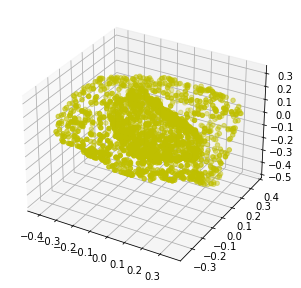

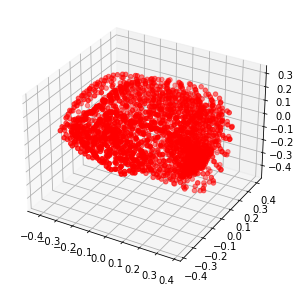

In [62]:
# from open3d.visualization import draw_geometries  
# import pptk
# import numpy as np
number = 100
points = all_inputs[number]
print(points.shape)




outs = all_outputs[number]

# v = pptk.viewer(points)
# draw_geometries([])

# xyz = pptk.rand(100, 3)
# v = pptk.viewer(xyz)
# v.capture('screenshot.png')
# v.clear()
# v.close()

# import numpy as np
# import pyvista as pv
# from pyvista import examples
# point_cloud = pv.PolyData(points)
# point_cloud
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(5,5))

ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c='y', marker='o', s=20)

# ax[2] = plt.axes(projection='3d')
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter(outs[:,0], outs[:,1], outs[:,2], c='r', marker='o', s=20)

In [67]:
newlab = []
for i in range(len(labels)):
    newlab.append(labels[i][0])

IndexError: invalid index to scalar variable.

In [12]:
import umap
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scaled_features = scalar.fit_transform(all_feat)
# UMAP for vizualization
reducer = umap.UMAP()
# embedding = reducer.fit_transform(scaled_features)
embedding = reducer.fit_transform(scaled_features)

/home/mvries/anaconda3/envs/dcc/lib/python3.8/site-packages/umap/spectral.py:343: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


/home/mvries/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


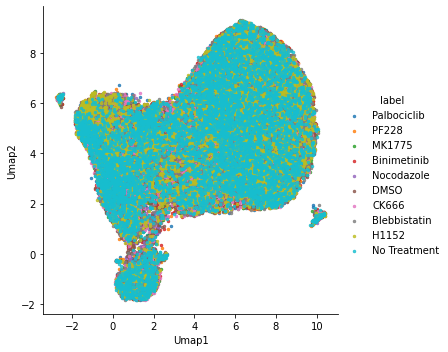

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

b = np.zeros((len(embedding), 2))
b[:, 0] = embedding[:, 0]
b[:, 1] = embedding[:, 1]

data = pd.DataFrame(b, columns=['Umap1','Umap2'])
data['label'] = np.asarray(labels)


facet = sns.lmplot(data=data, x='Umap1', y='Umap2', hue='label',
                   fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 6})


plt.show()

In [14]:
labels

['Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palbociclib',
 'Palboc

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                        data['label'],
                                                        random_state=42, 
                                                        test_size=0.33)
    
clf = svm.SVC(kernel='linear', C=1, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


print(clf.score(X_train, y_train))

In [57]:
print(clf.score(X_test, y_test))

0.891459512675363


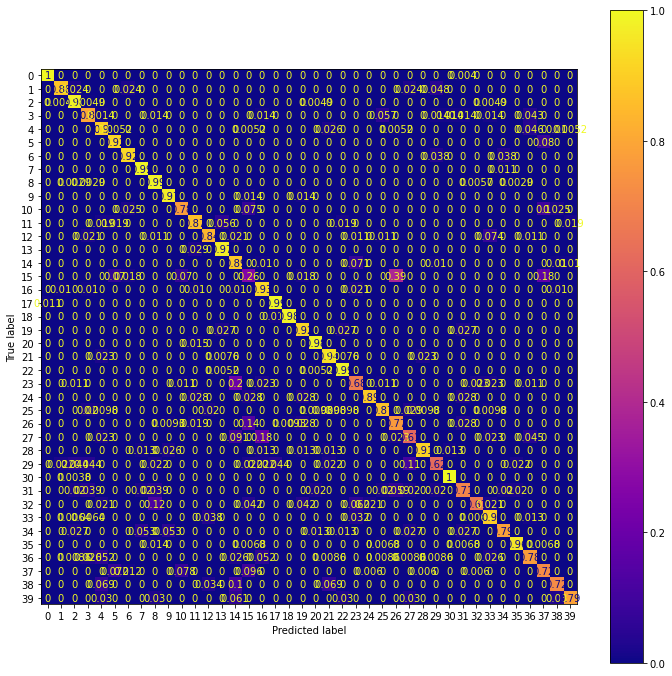

In [58]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax, cmap=plt.cm.plasma)  
cm.ax_.get_images()[0].set_clim(0, 1)
plt.show()

In [18]:
xy = pd.DataFrame(scaled_features)
xy['label'] = data['label']
blebb_noc = xy[(xy['label'] == 'Nocodazole')|
              (xy['label'] == 'Blebbistatin')]

In [19]:
blebb_noc

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
2856,0.009299,-0.585826,0.316189,0.659141,-0.657999,-0.092561,-0.291134,-0.374275,-0.498523,-0.130901,...,0.178655,0.994830,-0.934656,-0.756114,0.069758,0.588432,-0.168659,0.294818,-0.446102,Nocodazole
2857,0.143688,-0.456033,0.293220,0.989197,-0.471867,-0.049108,-0.793594,-0.965957,-0.974966,0.771788,...,-0.214910,0.866104,-0.650592,0.154444,-0.180627,0.944781,0.289156,0.265847,-0.435352,Nocodazole
2858,0.329630,-0.659433,-0.161303,0.994129,-0.507399,0.413992,-0.413414,-0.488058,-0.375899,-0.250106,...,0.498536,0.551536,-0.571630,-0.383648,-0.226826,0.073560,0.299353,-0.187910,-0.020539,Nocodazole
2859,0.549008,-0.555643,-0.036572,0.597605,-0.277189,0.533511,-1.146374,-0.827940,-0.469401,0.778555,...,-0.159926,1.198295,-1.017728,-0.323250,-0.768834,0.500329,0.037372,-0.247869,-0.713450,Nocodazole
2860,0.515852,-0.173445,-0.510143,0.900459,-0.238881,0.166990,0.041025,-0.673749,-0.746147,-0.150943,...,0.285550,0.482640,-0.644549,0.467313,-0.216168,0.147190,0.265898,-0.386447,0.049919,Nocodazole
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69316,-0.124339,2.450073,2.740698,-1.725197,0.226129,-1.116827,-0.432354,2.019639,-0.397834,0.586675,...,-1.345499,-2.379510,2.509939,-0.641487,-2.493702,-0.304414,-0.537381,0.426185,0.512944,Blebbistatin
69317,-1.871369,-0.169266,1.495763,-0.384054,0.788337,-1.177665,0.574173,-1.456462,0.652921,0.316794,...,-0.357102,-0.254056,0.984742,-0.036772,1.505452,0.467183,-1.100636,1.321497,-0.130157,Blebbistatin
69318,0.431658,-0.195493,-0.707365,-0.545485,-0.382634,1.614999,1.744840,-0.312724,2.450735,1.424234,...,0.598636,-0.836392,-0.800153,0.090381,-0.579370,-3.793878,-0.368786,-2.465289,-0.766534,Blebbistatin
69319,0.845603,-0.048764,0.669008,-0.436411,-1.494766,1.536911,0.757075,0.461606,1.516102,3.040753,...,-1.615010,-1.047880,-0.280168,-0.647611,-0.823293,-2.066917,-0.955569,-1.553334,-2.319743,Blebbistatin


In [24]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(blebb_noc.iloc[:,:-1], 
                                                        blebb_noc['label'],
                                                        random_state=0, 
                                                        test_size=0.33)
    
clf = svm.SVC(kernel='linear', C=1, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


print(clf.score(X_train, y_train))

0.8265782896881452


In [25]:
print(clf.score(X_test, y_test))

0.8266431407146008


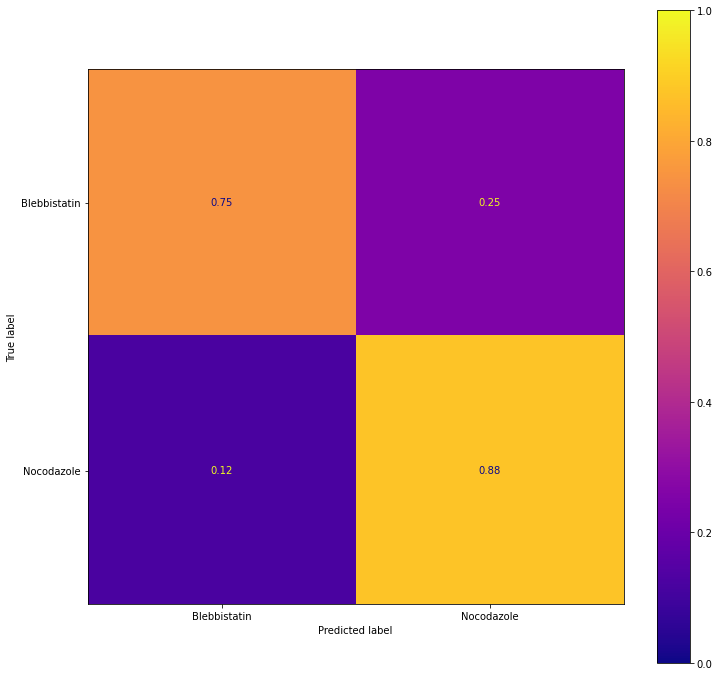

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax, cmap=plt.cm.plasma)  
cm.ax_.get_images()[0].set_clim(0, 1)
plt.show()